In [6]:
import pandas as pd

df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", header=None, encoding="latin1", sep=",", on_bad_lines='skip')  
df.columns = ["Polarity", "ID", "Date", "Flag", "User", "Tweet"]
texts = df["Tweet"]
labels = df["Polarity"]

In [7]:

import pandas as pd
import nltk
import re
import string

# ... (rest of your code) ...

def clean_text(tweet):
    # Check if the input is a string, convert if not
    if not isinstance(tweet, str):
        tweet = str(tweet)
    
    tweet= re.sub('(#|@)\w*','',tweet)
    tweet= re.sub('https?:\/\/\S+','',tweet)
    tweet= re.sub('(\?|\!)+','',tweet)
    tweet= re.sub('^\s+','',tweet)
    tweet= re.sub('\s+$','',tweet)
    tweet= re.sub('(\.|\,)+','',tweet)
    tweet= re.sub('[:()\\\]','',tweet)
    tweet= re.sub('\s\d+\s','',tweet)
    tweet = tweet.lower()  
    tweet = re.sub(r"\d+", "", tweet) 
    tweet = tweet.translate(str.maketrans("", "", string.punctuation)) 
    tweet = tweet.strip()
    return tweet



In [8]:
df["clean_feedback"] = texts.apply(clean_text)  


In [9]:
from textblob import TextBlob  

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["clean_feedback"].apply(get_sentiment)  


In [10]:
# Check the count of classifications "Positive", "Negative", "Neutral"
polarity_counts = df["sentiment"].value_counts()
print("Sentiment counts:")
print(polarity_counts)

Sentiment counts:
sentiment
Positive    682930
Neutral     575364
Negative    341706
Name: count, dtype: int64


In [11]:
import pandas as pd

#Calculate the minimum count among the classes
min_count = df["sentiment"].value_counts().min()

# Take an equal-sized sample from each class
df_balanced = (
    df.groupby("sentiment")
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)

# Verify the balance
print(df_balanced["sentiment"].value_counts())


<ipython-input-11-48119155ef2a>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


sentiment
Negative    341706
Neutral     341706
Positive    341706
Name: count, dtype: int64


In [12]:
df_balanced.shape

(1025118, 8)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import gc
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [14]:
# Load the RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-large")

# Function to convert texts to tokens
def tokenize_texts(texts, max_length=128):
    encoding = tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return encoding["input_ids"], encoding["attention_mask"]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
# Convert texts to tokens
input_ids, attention_masks = tokenize_texts(df_balanced["clean_feedback"])


In [16]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df_balanced["sentiment"]))

# Clear memory
gc.collect()


0

In [17]:
from torch.utils.data import Dataset, DataLoader

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    input_ids, labels, attention_masks, test_size=0.25, random_state=42
)

# Create a custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx]
        }

# Create DataLoaders
batch_size = 64  # Try larger values if performance is good
train_dataset = SentimentDataset(X_train, mask_train, y_train)
test_dataset = SentimentDataset(X_test, mask_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [18]:
# Load pre-trained RoBERTa model for classification
model = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=3)

# Set up the Optimizer & Loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Ensure the code runs on `GPU`
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
**************************************************************************
def train_fn(train_loader, model, optimizer, num_epochs=5, patience=2):
    model.to(device)
    
    best_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        start_time = time.time()

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            
            optimizer.step()  # ✅ تحديث المعاملات على `GPU`

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"📌 Epoch {epoch+1}: Average Loss = {avg_loss:.4f}, Time = {(time.time() - start_time) / 60:.2f} دقيقة")
        

        # ✅ Early Stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⏳ Early Stopping: No improvement, stopping training.")
                break


In [20]:
import torch.amp as amp

def train_fn(train_loader, model, optimizer, num_epochs=5, patience=2):
    model.to(device)
    scaler = amp.GradScaler(device="cuda")  # new version

    best_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        start_time = time.time()

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with amp.autocast(device_type="cuda"):  # using the new version
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}, Time = {(time.time() - start_time) / 60:.2f} minutes")

        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early Stopping: No improvement, stopping training.")
                break


In [21]:
# Run the training
train_fn(train_loader, model, optimizer, num_epochs=2, patience=3)


Epoch 1/2: 100%|██████████| 12014/12014 [4:04:38<00:00,  1.22s/it] 


Epoch 1: Average Loss = 0.0905, Time = 244.65 minutes


Epoch 2/2: 100%|██████████| 12014/12014 [4:04:21<00:00,  1.22s/it] 

Epoch 2: Average Loss = 0.0365, Time = 244.37 minutes


In [22]:
import shutil

# Save the model
model_save_path = "roberta_sentiment_model.pt"
torch.save(model.state_dict(), model_save_path)

# If you are on Kaggle or Colab, move the file to the working directory
shutil.move(model_save_path, "/kaggle/working/roberta_sentiment_model.pt")  # For Kaggle

print(f"Model saved at {model_save_path}")


Model saved at roberta_sentiment_model.pt


In [23]:
import os

# Create a directory to save the model
model_dir = "/kaggle/working/roberta_trained"
os.makedirs(model_dir, exist_ok=True)

# Save the model and the tokenizer
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

print(f"Model and tokenizer saved in: {model_dir}")


Model and tokenizer saved in: /kaggle/working/roberta_trained


In [24]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set the model to evaluation mode
model.eval()

# Store predictions and true labels
predictions = []
true_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to final class predictions
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Print results
print("Accuracy:", accuracy_score(true_labels, predictions))
print("\nClassification Report:\n", classification_report(true_labels, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(true_labels, predictions))


Accuracy: 0.9911503043546122

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     85450
           1       0.99      0.99      0.99     85468
           2       0.99      0.99      0.99     85362

    accuracy                           0.99    256280
   macro avg       0.99      0.99      0.99    256280
weighted avg       0.99      0.99      0.99    256280


Confusion Matrix:
 [[84792   339   319]
 [  396 84803   269]
 [  813   132 84417]]


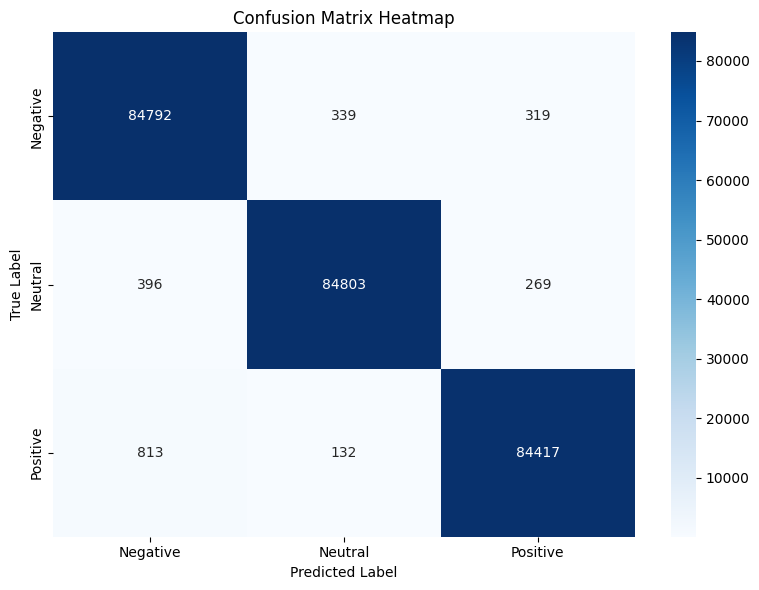

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# If you don't have the matrix, calculate it
y_true = true_labels
y_pred = predictions
cm = confusion_matrix(y_true, y_pred)

# Class labels according to your order (change if you have a different order)
labels = ["Negative", "Neutral", "Positive"]

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set the model to evaluation mode
model.eval()

# Store predictions and true labels
predictions = []
true_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)


In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print(f"Model accuracy: {accuracy:.4f}")
